In [26]:
import json
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [5]:
data_dir = "BrainTumorDataset"

In [6]:
def load_coco_annotations(json_file):
    """
    Loads and returns the annotations from a COCO-style JSON file.

    Args:
        json_file (str): Path to the COCO annotations JSON file.

    Returns:
        dict: Dictionary containing images, annotations, and categories.
            - images: List of image metadata.
            - annotations: List of annotation objects.
            - categories: List of category definitions.
    """
    try:
        with open(json_file, 'r') as file:
            coco_data = json.load(file)
        
        # Extract specific sections
        images = coco_data.get('images', [])
        annotations = coco_data.get('annotations', [])
        categories = coco_data.get('categories', [])
        
        return {
            'images': images,
            'annotations': annotations,
            'categories': categories
        }
    except FileNotFoundError:
        print(f"Error: File '{json_file}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON file '{json_file}'.")
        return None

In [7]:
# Load the train/validation/test annotations and store in a dictionary
train_annotations_path = f'{data_dir}/train/_annotations.coco.json'
valid_annotations_path = f'{data_dir}/valid/_annotations.coco.json'
test_annotations_path = f'{data_dir}/test/_annotations.coco.json'

train_annotations_dict = load_coco_annotations(train_annotations_path)

In [8]:
print(train_annotations_dict['annotations'])

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}, {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [194, 176, 148.75, 233.75], 'area': 34770.313, 'segmentation': [[342.5, 176.25, 193.75, 176.25, 193.75, 410, 342.5, 410, 342.5, 176.25]], 'iscrowd': 0}, {'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [133, 173, 162.5, 185], 'area': 30062.5, 'segmentation': [[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, 357.5, 295, 172.5]], 'iscrowd': 0}, {'id': 3, 'image_id': 3, 'category_id': 1, 'bbox': [245, 358, 138.75, 166.25], 'area': 23067.188, 'segmentation': [[383.75, 357.5, 245, 357.5, 245, 523.75, 383.75, 523.75, 383.75, 357.5]], 'iscrowd': 0}, {'id': 4, 'image_id': 4, 'category_id': 1, 'bbox': [80, 189, 112.5, 132.5], 'area': 14906.25, 'segmentation': [[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5, 321.25, 192.5, 188.75]], 'iscrowd': 

In [9]:
def generate_segmentation_masks_brain_tumor(annotation_file, image_dir, mask_dir):
    """
    Generates binary segmentation masks for a brain tumor dataset.

    Args:
        annotation_file (str): Path to the COCO annotations JSON file.
        image_dir (str): Directory containing images.
        mask_dir (str): Directory to save generated masks.

    Returns:
        None
    """
    # Load COCO annotations
    coco = COCO(annotation_file)
    os.makedirs(mask_dir, exist_ok=True)
    
    for img_id in coco.getImgIds():
        # Load image metadata
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(image_dir, img_info['file_name'])
        
        # Load annotations for the image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        # Create an empty binary mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        
        for ann in annotations:
            if ann['segmentation']:
                for seg in ann['segmentation']:
                    # Convert segmentation to Nx2 array of coordinates
                    polygon = np.array(seg, dtype=np.int32).reshape((-1, 2))

                    print(f"Processing Image: {img_info['file_name']} with annotation:", ann['category_id'])

                    # Set mask based on category_id
                    if ann['category_id'] == 1:  # No tumor
                        cv2.fillPoly(mask, [polygon], color=0)  # Explicitly set to background (no tumor)
                    elif ann['category_id'] == 2:  # Tumor present
                        cv2.fillPoly(mask, [polygon], color=255)  # Explicitly set to foreground (tumor)

        # Validate mask values (should only contain 0 and 1)
        mask[mask > 1] = 1
        
        # Save the mask
        mask_filename = f"{img_info['file_name'].split('.jpg')[0]}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)  # Save as grayscale (0 and 1)

In [10]:
# Create directories to store the original images and created masks for the train, validation, and test datasets
train_image_path = f'{data_dir}/train/images/'
train_mask_path = f'{data_dir}/train/mask/'
valid_image_path = f'{data_dir}/valid/images/'
valid_mask_path = f'{data_dir}/valid/mask/'
test_image_path = f'{data_dir}/test/images/'
test_mask_path = f'{data_dir}/test/mask/'

In [11]:
# Create the masks for each image, a category ID = 1 signifies no tumor and category ID = 2 signifies a tumor is present
generate_segmentation_masks_brain_tumor(train_annotations_path, train_image_path, train_mask_path)
generate_segmentation_masks_brain_tumor(valid_annotations_path, valid_image_path, valid_mask_path)
generate_segmentation_masks_brain_tumor(test_annotations_path, test_image_path, test_mask_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Processing Image: 2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg with annotation: 1
Processing Image: 2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg with annotation: 1
Processing Image: 2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg with annotation: 1
Processing Image: 2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg with annotation: 1
Processing Image: 2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg with annotation: 1
Processing Image: 2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg with annotation: 1
Processing Image: 2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg with annotation: 1
Processing Image: 1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg with annotation: 2
Processing Image: 1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg with annotation: 2
Processing Image: 2534_jpg.rf.3c8c86666860368d46b8f7bcd95ac220.jpg with annotation: 1
Processing Image: 2433_jpg.rf.3cdf8e4cb3a08e9b2fccc6c6082

In [12]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.mask_filenames = os.listdir(mask_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Convert images to RGB since the FCN_Resnet model is pretrained on ImageNet, which uses 
        # 3-channel RGB images
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()
            
        image_filename = os.path.basename(image_path)

        return image, mask, image_filename

In [178]:
# Define transforms for both image and mask
train_transform = A.Compose([
    A.Resize(height=256, width=256, p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=5, p=0.5),
    A.Affine(translate_percent=(0.1, 0.1), p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),  # Applied only to image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Ensures mask is transformed with the same spatial ops

valid_transform = A.Compose([
    A.Resize(height=256, width=256, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

test_transform = A.Compose([
    A.Resize(height=256, width=256, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [179]:
# Create the datasets and dataloaders
train_dataset = BrainTumorDataset(train_image_path, train_mask_path, train_transform)
valid_dataset = BrainTumorDataset(valid_image_path, valid_mask_path, valid_transform)
test_dataset = BrainTumorDataset(test_image_path, test_mask_path, test_transform)

In [98]:
# Define the dice loss metric
def dice_loss(pred, target, epsilon=1e-6, smooth=0.1):
    # Apply sigmoid to get probabilities from logits
    pred = torch.sigmoid(pred)

    # Flatten the predictions and target
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1).float()
        
    # Label smoothing
    if smooth > 0.0:
        target_flat = (1 - smooth) * target_flat + smooth * 0.5
    
    # Compute the intersection and union
    intersection = torch.sum(pred_flat * target_flat, dim=1)
    union = torch.sum(pred_flat, dim=1) + torch.sum(target_flat, dim=1)

    # Dice coefficient and loss
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return 1 - dice.mean()

In [141]:
# Define focal loss for binary segmentation
def focal_loss(pred, target, alpha=1.0, gamma=2.0):
    pred = pred.squeeze(1) # From [B, 1, H, W] to [B, H, W]
    target = target.float()
    bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    pt = torch.exp(-bce_loss) # how confident the model is in the correct prediction
    focal = alpha * (1 - pt) ** gamma * bce_loss

    return focal.mean()

In [133]:
# Combined focal and dice loss
def combined_dice_focal_loss(pred, target, alpha=1.0, gamma=2.0, dice_weight=1.0, focal_weight=1.0):
    dice = dice_loss(pred, target)
    focal = focal_loss(pred, target, alpha, gamma)

    return dice_weight * dice + focal_weight * focal

In [142]:
def combined_dice_ce_loss(pred, target, dice_weight=1.0, ce_weight=1.0):
    dice = dice_loss(pred, target)

    pred = pred.squeeze(1) # From [B, 1, H, W] to [B, H, W]
    target = target.float()
    bce = F.binary_cross_entropy_with_logits(pred, target)

    return dice_weight * dice + ce_weight * bce

In [33]:
# Define learning rate scheduler with warmup period
def get_linear_warmup_scheduler(optimizer, base_lr, num_epochs, num_warmup=3):
    def lr_lambda(epoch):
        return min(1.0, (epoch+1) / num_warmup)

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Halve learning rate if loss doesn't improve after 3 epochs
def get_plateau_scheduler(optimizer):
    return lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5, # halve the loss
        threshold=1e-4,
        patience=3) # apply after 3 epochs of non-improving loss

In [180]:
# Load the pretrained UNet model and adapt for segmentation with 2 classes (tumor/no tumor)
model = smp.Unet(
    encoder_name='resnet18',         
    encoder_weights='imagenet',      # use pretrained weights
    in_channels=3,                   # input image channels
    classes=1,                       # binary output where model outputs likelihood of being part of tumor class
    decoder_dropout=0.5              
)

In [181]:
# Set hyperparameters
criterion = lambda pred, target: combined_dice_ce_loss(pred, target, dice_weight=0.75, ce_weight=1.25)
batch = 16
learning_rate = 0.0001
decay = 0.01
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=decay)
num_epochs = 20
warmup_epochs = 3
warmup_scheduler = get_linear_warmup_scheduler(optimizer, learning_rate, num_epochs, warmup_epochs)
plateau_scheduler = get_plateau_scheduler(optimizer)
best_model_path = "best_model.pth"  # Path to save the best model based on validation loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [183]:
# Training loop
model.to(device)

# Store the model with the best performance on the validation set
best_val_loss = float('inf')

all_training_losses = []
all_validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Get the current learning rate from the applicable scheduler
    current_lr = (warmup_scheduler.get_last_lr()[0] if epoch < warmup_epochs
    else plateau_scheduler.optimizer.param_groups[0]['lr']
    )
    print(f"Epoch {epoch+1}: LR = {current_lr:.6f}")

    for images, masks, files in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    all_training_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Train Combined Loss: {avg_train_loss:.4f}")

    # Evaluate performance on validation dataset
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for images, masks, files in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(valid_loader)
    all_validation_losses.append(avg_valid_loss)
    print(f"Average Validation Combined Loss: {avg_valid_loss:.4f}")

    # Save the model if it has the lowest validation loss
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with average validation combined loss: {best_val_loss:.4f}")

    # Step the LR warmup scheduler
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        plateau_scheduler.step(avg_valid_loss)

Epoch 1: LR = 0.000033
Epoch [1/20], Avg Train Combined Loss: 1.3629
Average Validation Combined Loss: 1.2196
New best model saved with average validation combined loss: 1.2196
Epoch 2: LR = 0.000067
Epoch [2/20], Avg Train Combined Loss: 1.0840
Average Validation Combined Loss: 0.9993
New best model saved with average validation combined loss: 0.9993
Epoch 3: LR = 0.000100
Epoch [3/20], Avg Train Combined Loss: 0.9352
Average Validation Combined Loss: 0.8898
New best model saved with average validation combined loss: 0.8898
Epoch 4: LR = 0.000100
Epoch [4/20], Avg Train Combined Loss: 0.8613
Average Validation Combined Loss: 0.8462
New best model saved with average validation combined loss: 0.8462
Epoch 5: LR = 0.000100
Epoch [5/20], Avg Train Combined Loss: 0.8254
Average Validation Combined Loss: 0.8190
New best model saved with average validation combined loss: 0.8190
Epoch 6: LR = 0.000100
Epoch [6/20], Avg Train Combined Loss: 0.8002
Average Validation Combined Loss: 0.8005
New b

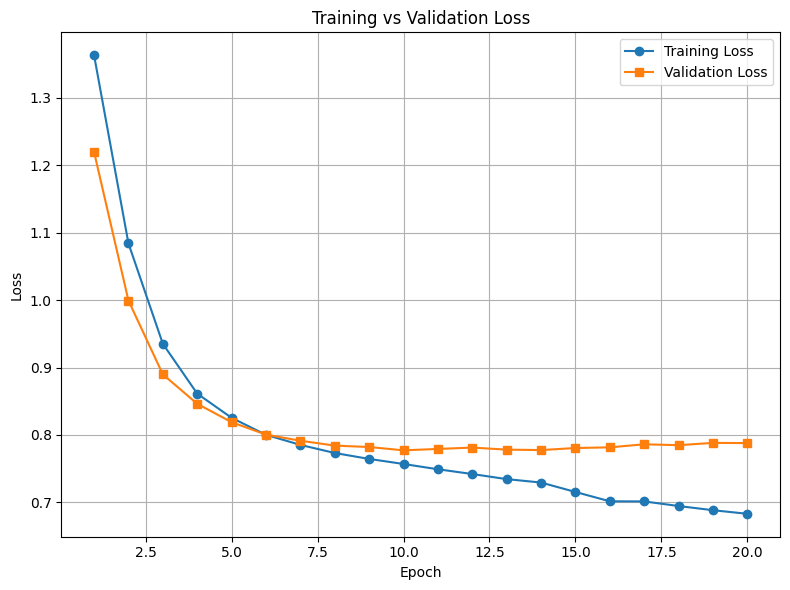

In [184]:
epochs = range(1, len(all_training_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, all_training_losses, label='Training Loss', marker='o')
plt.plot(epochs, all_validation_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
# Evaluate performance on the test set and display a few samples
test_loss = 0
num_samples_to_display = 3
sampled_images = []

all_preds = []
all_targets = []

model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

with torch.no_grad():
    for idx, (images, masks, filenames) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Get sigmoid probabilities for class 1 (tumor)
        probs = torch.sigmoid(outputs)
        
        # Convert predictions/masks to binary (0 = no tumor, 1 = tumor)
        binary_preds = (probs > 0.5).long().cpu().numpy().flatten()
        binary_targets = (masks > 0).long().cpu().numpy().flatten()

        all_preds.extend(binary_preds)
        all_targets.extend(binary_targets)

        # Store samples for visualization
        binary_masks = (masks > 0).long()
        # Iterate over the batch
        for i in range(len(filenames)):
            # Check if any pixel in the mask has a tumor
            tumor_present = binary_masks[i].cpu().numpy().any()
            
            # Store images for visualization
            if tumor_present and len(sampled_images) < num_samples_to_display:
                sampled_images.append((images[i].cpu(), masks[i].cpu(), outputs[i].cpu(), filenames[i]))

test_loss /= len(test_loader)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
f1 = f1_score(all_targets, all_preds, zero_division=0)

print(f"Average Test Dice Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Average Test Dice Loss: 0.7768
Test Precision: 0.1392, Recall: 0.3479, F1 Score: 0.1988


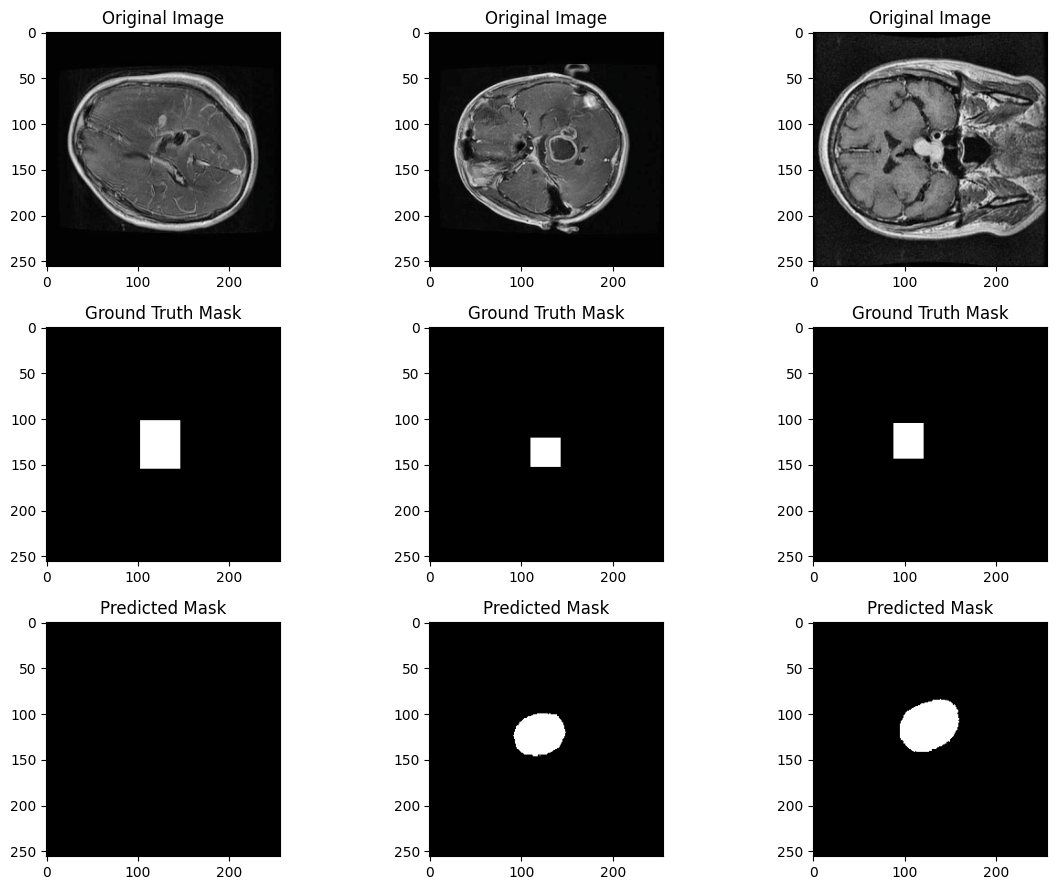

In [186]:
# ImageNet normalization settings
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3).to(device)

num_samples = len(sampled_images)
fig, axes = plt.subplots(3, num_samples, figsize=(4 * num_samples, 9))

for i, (image, mask, output, filename) in enumerate(sampled_images):    
    # Ensure the image is in HxWxC format
    image = image.permute(1, 2, 0).numpy()
    
    # Denormalize the image if needed
    image = image * std.cpu().numpy() + mean.cpu().numpy()
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    
    # Convert mask and output to numpy (for visualization)
    mask = mask.squeeze().cpu().numpy()

    # Apply sigmoid and threshold to get binary prediction
    output = torch.sigmoid(output) # Shape will be [1, H, W]
    output = (output > 0.5).float()  # Make output binary with threshold
    output = output.squeeze().cpu().numpy()

    # Plot the images, mask, and predicted mask
    axes[0, i].imshow(image, cmap="gray")  # Original Image
    axes[0, i].set_title("Original Image")
    axes[1, i].imshow(mask, cmap="gray")  # Ground truth mask
    axes[1, i].set_title("Ground Truth Mask")
    axes[2, i].imshow(output, cmap="gray")  # Predicted mask
    axes[2, i].set_title("Predicted Mask")

plt.tight_layout()
plt.show()